## Prize Collecting Steiner Tree (PCST)

### Problem definition

>**Given**
> * A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$;
> * A root node $\{0\}$;
> * A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$;

>
>**Find**
>A subtree $T$ rooted in $\{0\}$ that **maximizes** the sum of the revenues of 
>the nodes in $T$ **minus** the sum of the costs of the edges in $T$

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$

> **PCST** is equivalent to find an optimal **arborescence** in $B$ rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

#### Directed cut formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
\sum_{(i,j)\in \delta^+(S) x_{ij}} x_{ij}& \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$

### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [8]:
import networkx as nx
import gurobi as gb
import os
import matplotlib.pyplot as plt

#
# Drawing 
# functions
#

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40
    

In [9]:
# 
# Read the graph in the graphML format
#

args.filename = 'pcst.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


## Define the bidirected graph D from G

In [10]:
D = G.to_directed()

In [11]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30))

In [12]:
G.nodes(data=True)

NodeDataView({1: {'y': 27, 'x': 16, 'revenue': 822}, 2: {'y': 41, 'x': 14, 'revenue': 562}, 3: {'y': 7, 'x': 26, 'revenue': 412}, 4: {'y': 3, 'x': 14, 'revenue': 194}, 5: {'y': 25, 'x': 10, 'revenue': 189}, 6: {'y': 45, 'x': 17, 'revenue': 275}, 7: {'y': 13, 'x': 17, 'revenue': 344}, 8: {'y': 11, 'x': 23, 'revenue': 481}, 9: {'y': 2, 'x': 1, 'revenue': 143}, 10: {'y': 26, 'x': 22, 'revenue': 738}, 11: {'y': 26, 'x': 6, 'revenue': 992}, 12: {'y': 46, 'x': 23, 'revenue': 691}, 13: {'y': 23, 'x': 22, 'revenue': 185}, 14: {'y': 6, 'x': 24, 'revenue': 194}, 15: {'y': 3, 'x': 20, 'revenue': 872}, 16: {'y': 30, 'x': 16, 'revenue': 735}, 17: {'y': 20, 'x': 11, 'revenue': 551}, 18: {'y': 36, 'x': 15, 'revenue': 302}, 19: {'y': 4, 'x': 19, 'revenue': 990}, 20: {'y': 12, 'x': 3, 'revenue': 267}, 21: {'y': 18, 'x': 29, 'revenue': 923}, 22: {'y': 5, 'x': 1, 'revenue': 146}, 23: {'y': 43, 'x': 10, 'revenue': 705}, 24: {'y': 32, 'x': 6, 'revenue': 877}, 25: {'y': 46, 'x': 5, 'revenue': 278}, 26: {'y'

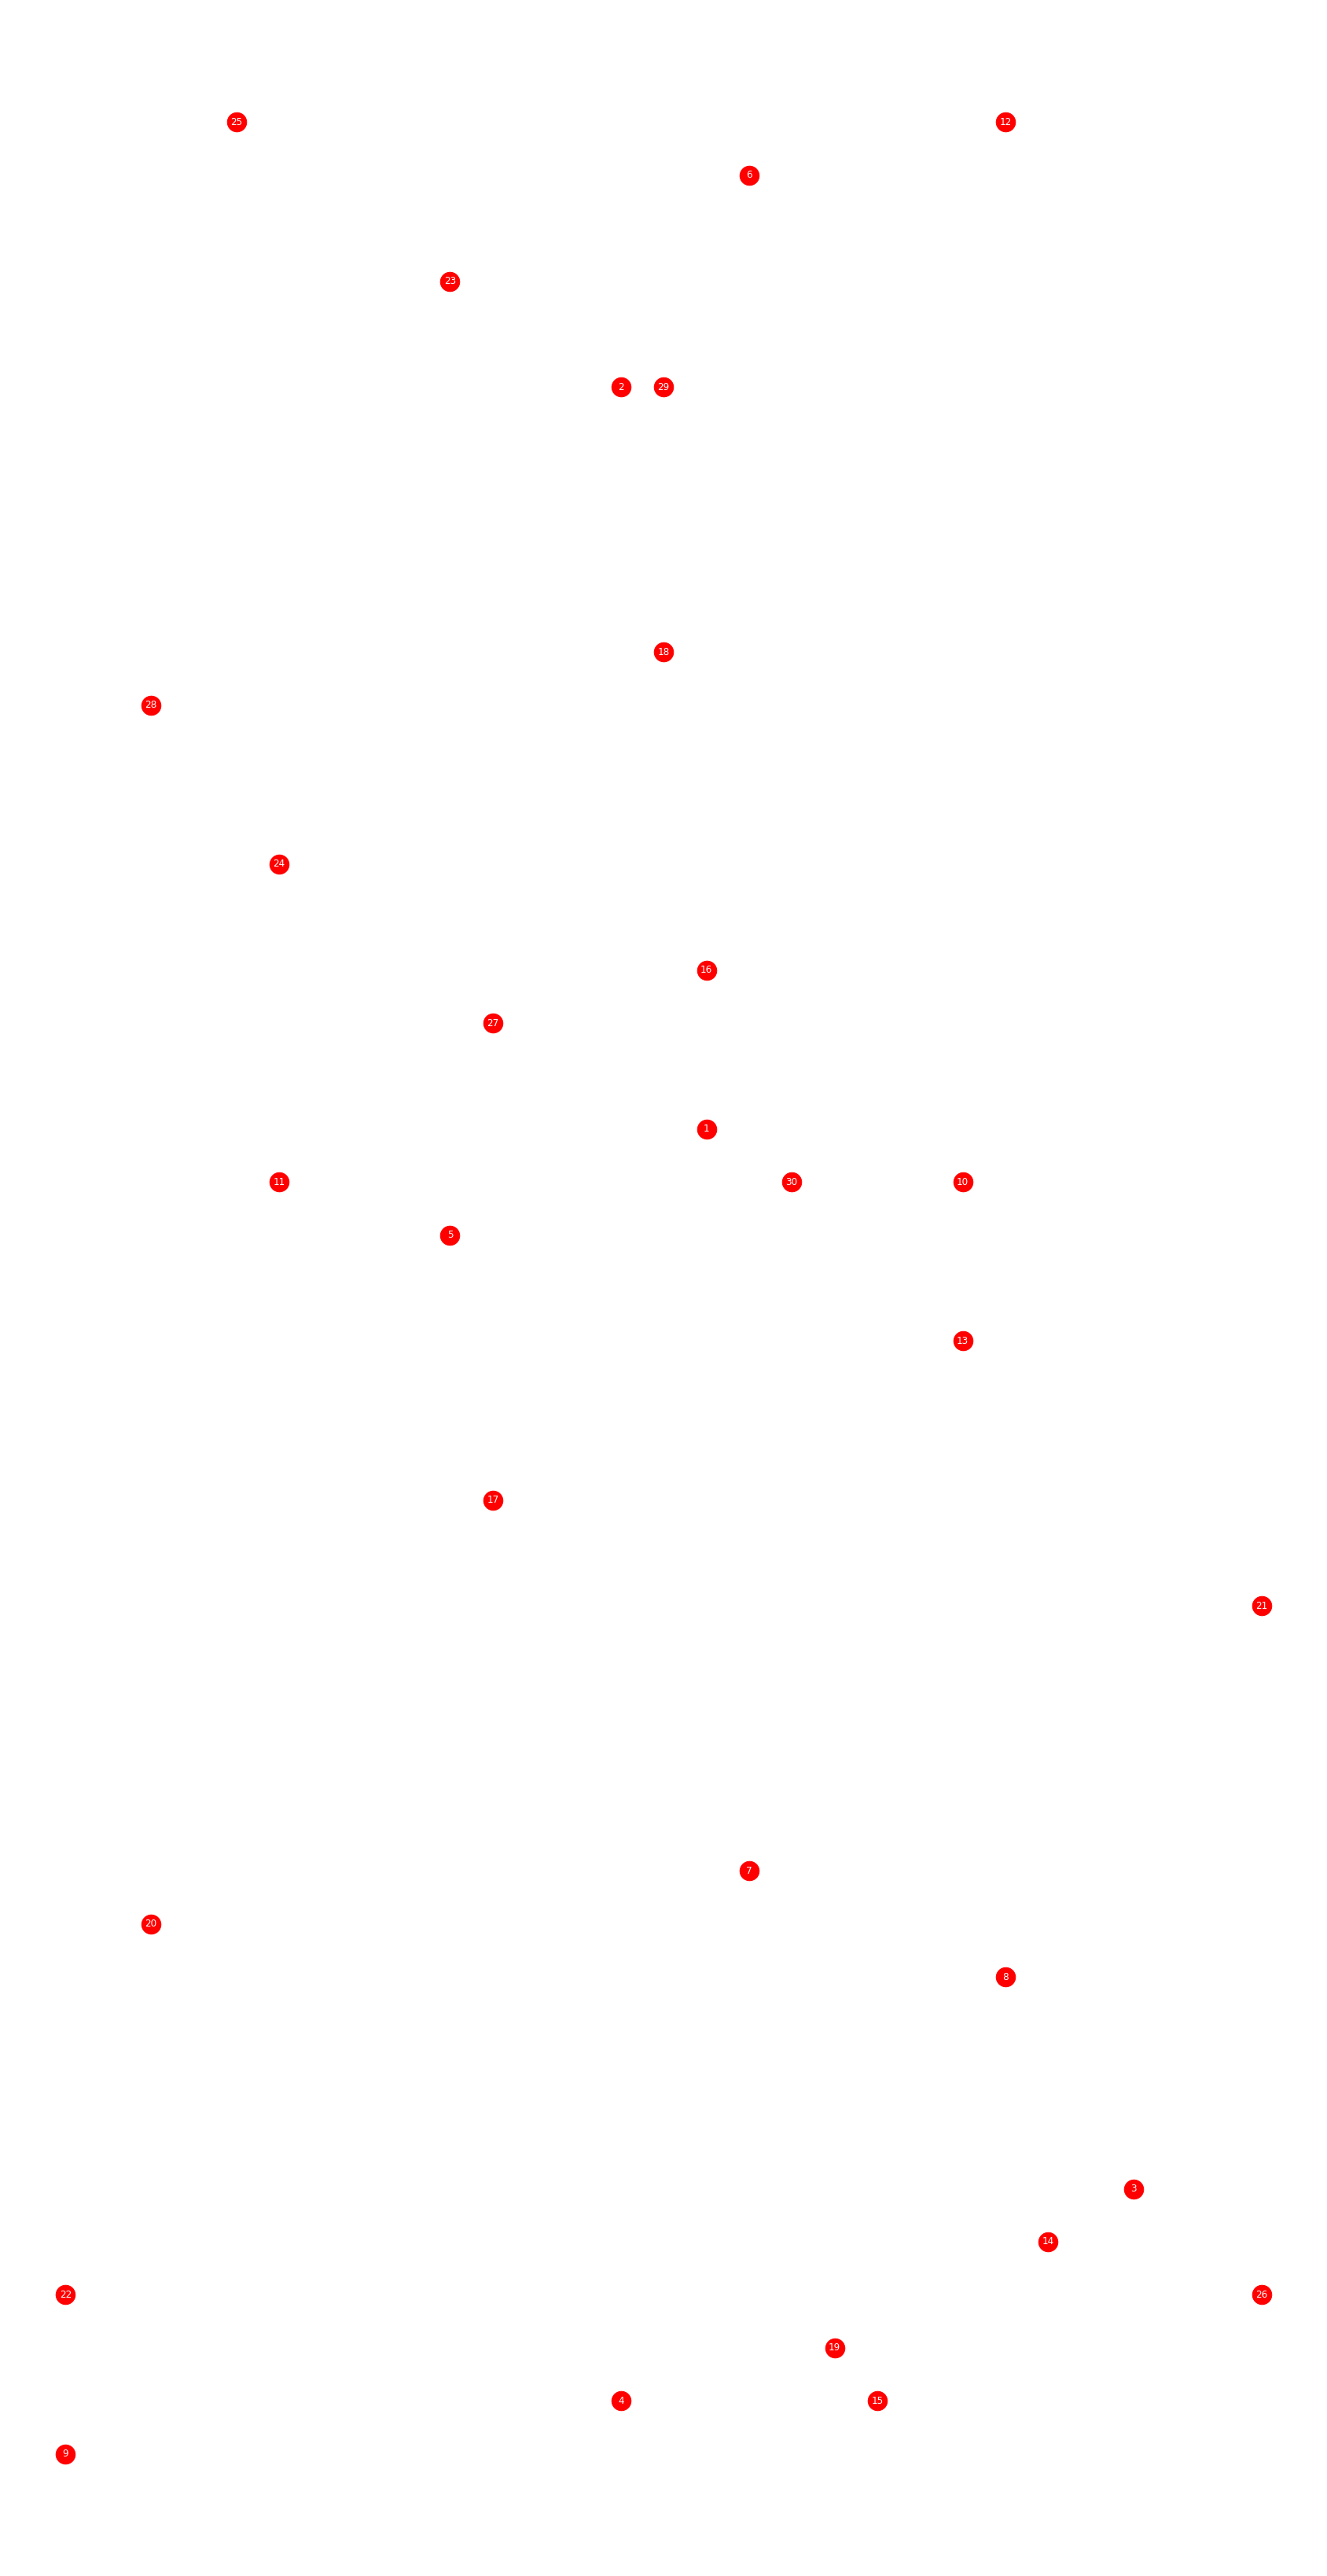

In [13]:
root = 1

pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}
DrawInitG(G)



In [14]:
pcst = gb.Model()



--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-15
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


In [15]:
#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE

In [16]:
pcst.write('pcst.lp')

In [17]:
#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

In [18]:
#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

pcst.update()

In [19]:
pcst.write('pcst.lp')

In [20]:
#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')

pcst.update()

In [21]:
pcst.write('pcst.lp')

In [22]:
#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 


In [23]:
pcst.write('pcst.lp')

In [24]:
pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1741 rows, 930 columns and 5163 nonzeros
Model fingerprint: 0xefa5198d
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 822.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.02s
Presolved: 1682 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 5.941968e+03, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5941.96774    0   22  822.00000 5941.96774   623%     -    0s
H    0     0                    1343.0000000 5941

In [25]:
totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            print (x[i,j])
            totalcost += D[i][j]['cost']

print ("Total cost", totalcost)

<gurobi.Var x[1,16] (value 1.0)>
<gurobi.Var x[1,30] (value 1.0)>
<gurobi.Var x[2,23] (value 1.0)>
<gurobi.Var x[3,14] (value 1.0)>
<gurobi.Var x[3,26] (value 1.0)>
<gurobi.Var x[8,3] (value 1.0)>
<gurobi.Var x[10,13] (value 1.0)>
<gurobi.Var x[13,21] (value 1.0)>
<gurobi.Var x[14,15] (value 1.0)>
<gurobi.Var x[15,19] (value 1.0)>
<gurobi.Var x[16,18] (value 1.0)>
<gurobi.Var x[16,27] (value 1.0)>
<gurobi.Var x[18,29] (value 1.0)>
<gurobi.Var x[21,8] (value 1.0)>
<gurobi.Var x[24,28] (value 1.0)>
<gurobi.Var x[27,11] (value 1.0)>
<gurobi.Var x[27,24] (value 1.0)>
<gurobi.Var x[29,2] (value 1.0)>
<gurobi.Var x[30,10] (value 1.0)>
Total cost 8482


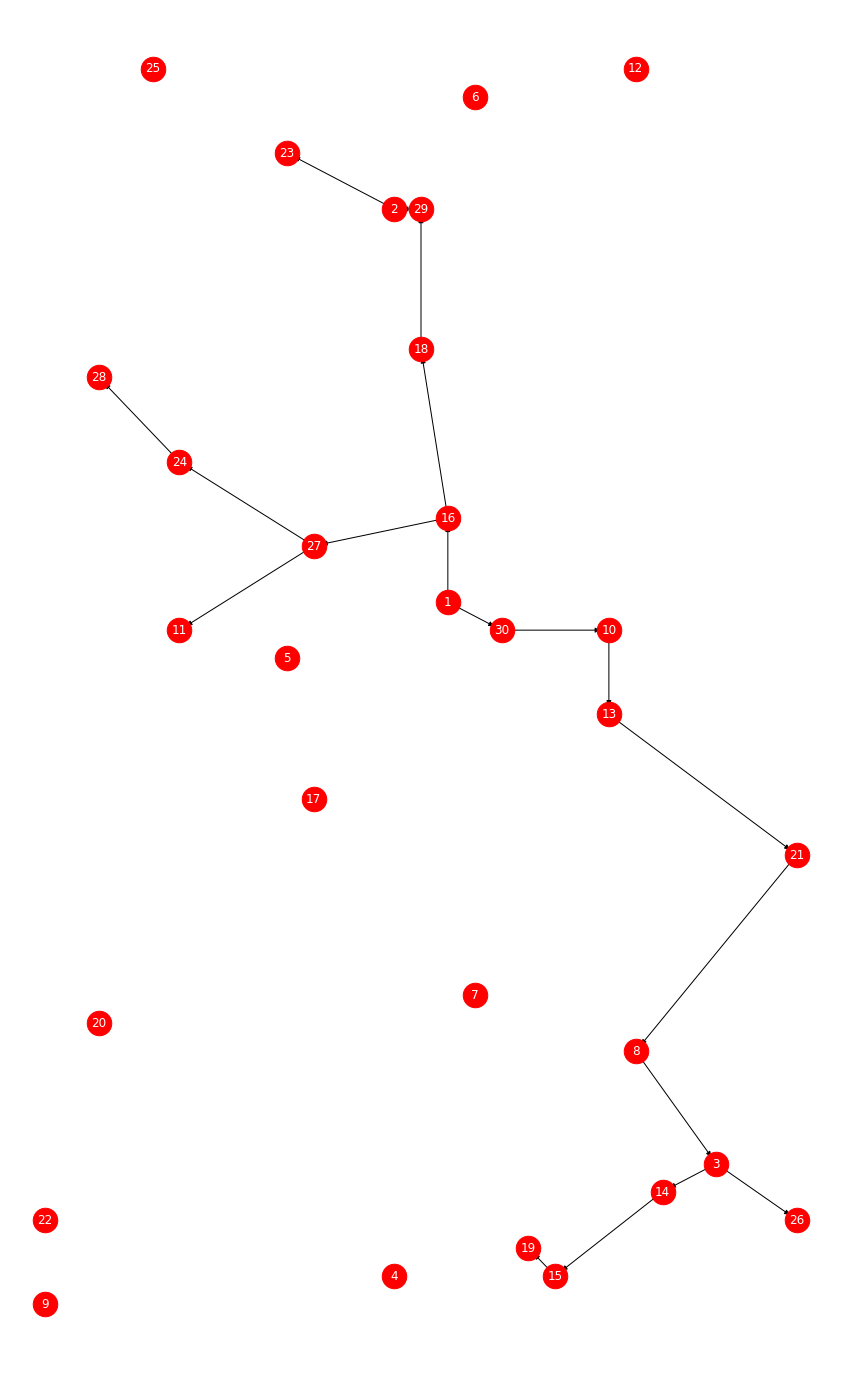

In [26]:
args.figsize = (15,25)

DrawSol(D,x)




### Now I add a budget on the total cost

In [27]:
budget = 4000

costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

$$ \sum_{(i,j) \in A} c_{ij} \cdot x_{ij} \le b $$

In [28]:
pcst.addConstr(x.prod(costs) <= budget, 'Budget')

pcst.update() 

pcst.write('pcst_budget.lp')

In [29]:
pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1742 rows, 930 columns and 6033 nonzeros
Model fingerprint: 0xcfbd2fdf
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint Budget by 4482.000000000

Found heuristic solution: objective 822.0000000
Presolve removed 553 rows and 173 columns
Presolve time: 0.07s
Presolved: 1189 rows, 757 columns, 7065 nonzeros
Variable types: 29 continuous, 728 integer (728 binary)

Root relaxation: objective 5.597518e+03, 71 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

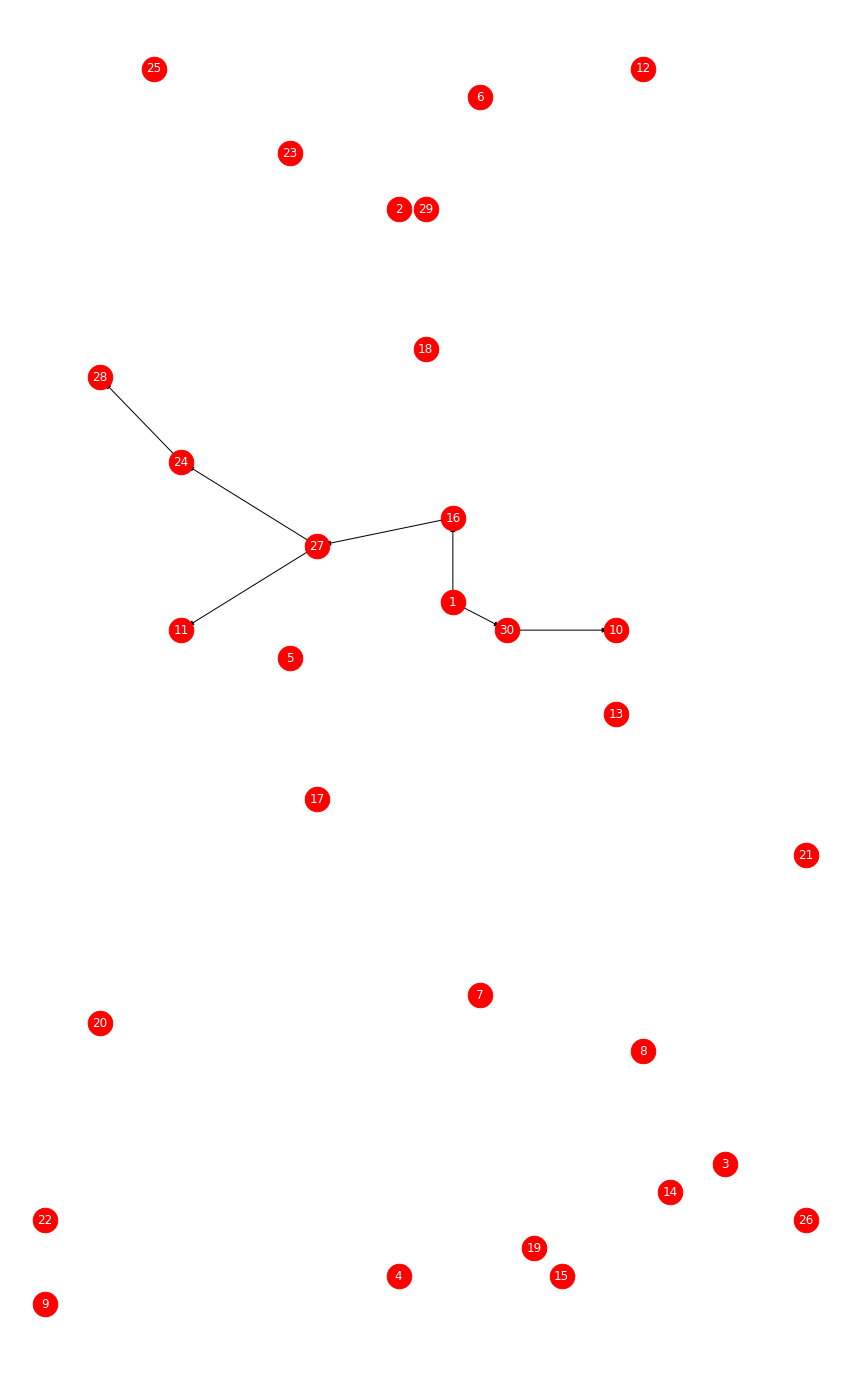

In [32]:
DrawSol(D,x)
